In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data, io, registration
import cv2
from scipy.spatial import distance
from scipy import ndimage
from tqdm import tqdm
import tifffile as tif
import matplotlib.cm as cm
from matplotlib.patches import RegularPolygon
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import os

In [5]:
from os.path import join as pjoin
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi
from dipy.data.fetcher import fetch_syn_data
from dipy.io.image import load_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.align import affine_registration, register_dwi_to_template

from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric
import dipy.align.imwarp as imwarp
from dipy.data import get_fnames
from dipy.io.image import load_nifti_data
from dipy.segment.mask import median_otsu
from dipy.viz import regtools

In [26]:
N1_211107_P36 = np.array([[247, 139], #0,1
                          [303, 171], #1,1
                          [299, 253], #1,0
                          [229, 301], #0,-1
                          [176, 291], #-1,-1
                          [193, 207]], #-1,0
                          np.int32)
N1_211107_P36 -= (25, 100)

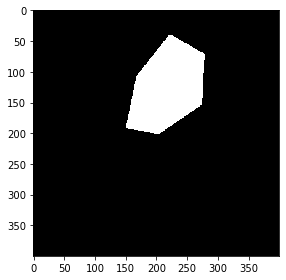

In [27]:
image = np.zeros((400,400))

N1_211107_P36 = N1_211107_P36.reshape((-1, 1, 2))
 
isClosed = True
 
# Line thickness of 2 px
thickness = 1
 
# Using cv2.polylines() method
# Draw a Blue polygon with
# thickness of 1 px
image = cv2.polylines(image, [N1_211107_P36],
                      isClosed, thickness)
image = np.array(ndimage.binary_fill_holes(image), dtype=np.float32)
io.imshow(image)

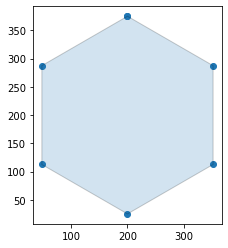

In [28]:
c = [200,200]
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

hexagon = RegularPolygon((c[0], c[1]), numVertices=6, orientation = np.radians(0), 
                            radius=175, alpha=0.2, edgecolor='k')
verts = hexagon.get_path().vertices
points = hexagon.get_patch_transform().transform(verts)
# points = trans.transform(verts)
ax.scatter(hexagon.get_verts()[:,0],hexagon.get_verts()[:,1])
ax.add_patch(hexagon)
plt.autoscale(enable = True)
# ax.scatter(hexagon.get_verts()[:,0],hexagon.get_verts()[:,1])
plt.show()
points = hexagon.get_verts().astype('int32')

In [29]:
points

array([[221, 243],
       [135, 194],
       [135,  95],
       [221,  45],
       [306,  95],
       [306, 194],
       [221, 243]], dtype=int32)

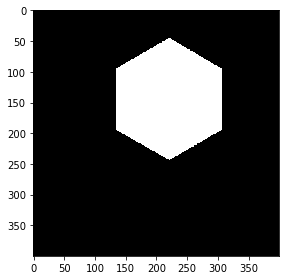

In [30]:
fixed = np.zeros((400,400))

points = points.reshape((-1, 1, 2))
 
isClosed = True
 
# Line thickness of 2 px
thickness = 1
 
# Using cv2.polylines() method
# Draw a Blue polygon with
# thickness of 1 px
fixed = cv2.polylines(fixed, [points],
                      isClosed, thickness)
fixed = np.array(ndimage.binary_fill_holes(fixed), dtype=np.float32)
io.imshow(fixed)

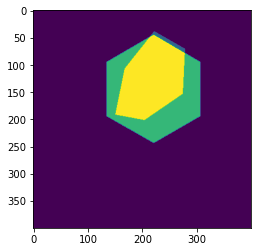

In [31]:
merge = image + 2*fixed
plt.imshow(merge)

In [32]:
com = transform_centers_of_mass(static=fixed,
                                static_grid2world=np.eye(3),
                                moving=image,
                                moving_grid2world=np.eye(3)
                               )
moving = com.transform(image)

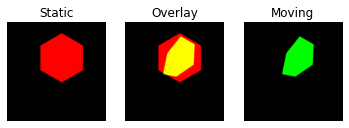

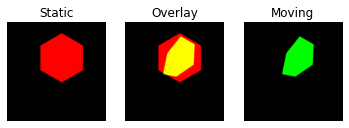

In [33]:
regtools.overlay_images(fixed, moving, 'Static', 'Overlay', 'Moving',
                        'input_images.png')

In [34]:
dim = fixed.ndim
metric = SSDMetric(dim)
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)

(array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        ...,
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.]], dtype=float32),
 array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
           0.      ],
        [  0.      , 126.999985, 126.99999 , ..., 127.      , 127.      ,
         127.      ],
        [  0.      , 126.99998 , 127.      , ..., 127.      , 127.      ,
         127.      ],
        ...,
        [  0.      , 127.      , 127.      , ..., 127.      , 127.      ,
         127.      ],
        [  0.      , 127.      , 127.      , ..., 127.      , 127.      ,
         127.      ],
        [  0.      , 127.      , 127.      , ..., 127.      , 127.      ,
         127.      ]], dtype=float32))

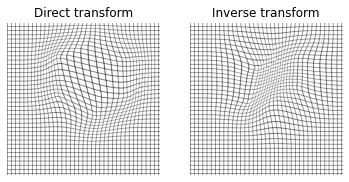

In [35]:
mapping = sdr.optimize(fixed, moving)
regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

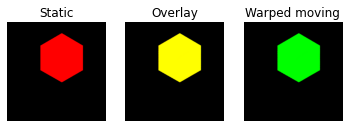

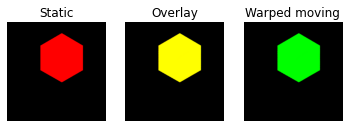

In [36]:
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(fixed, warped_moving, 'Static', 'Overlay',
                        'Warped moving', 'direct_warp_result.png')

In [37]:
test = tif.imread('/Users/aichah/Desktop/TLI/data/subtypeA/211104_P36_N2_R270_mask.tif')

In [38]:
test_trans = np.zeros(test.shape, np.int16)
for timepoint in tqdm(range(0,test.shape[0])):
    for vol_slice in range(0,test.shape[1]):
        test[timepoint,vol_slice] = mapping.transform(com.transform(test[timepoint, vol_slice]))

100%|██████████| 89/89 [02:00<00:00,  1.35s/it]


In [46]:
test_trans.sum()

0

In [187]:
tif.imwrite(file='/Users/aichah/Desktop/TLI/data/subtypeA/211104_P36_N2_R270_mask_transformed.tif', 
            data=test_trans, imagej=True, dtype=image.dtype, resolution=(1./0.076, 1./0.076),
            metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})


/Users/aichah/.local/lib/python3.9/site-packages/tifffile/tifffile.py:1420: UserWarning: TiffWriter: ignoring `dtype` argument
  warnings.warn(


In [190]:
test.shape

(89, 56, 400, 400)

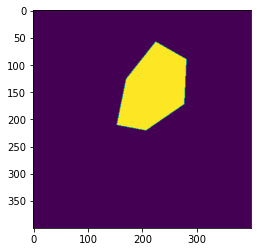

In [44]:
plt.imshow(moving)

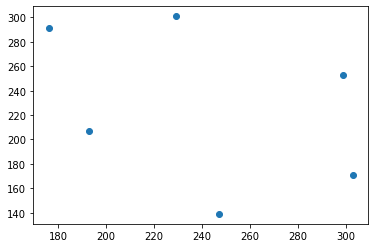

In [19]:
plt.scatter(N1_211107_P36[:,0],N1_211107_P36[:,1])

In [20]:
np.linalg.norm((N1_211107_P36[0]-N1_211107_P36[1])), np.linalg.norm((N1_211107_P36[2]-N1_211107_P36[3])), np.linalg.norm((N1_211107_P36[4]-N1_211107_P36[5]))

(162.9969324864735, 115.55085460523432, 174.72549899771354)

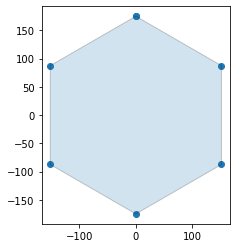

In [134]:
c = [0,0]
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

hexagon = RegularPolygon((c[0], c[1]), numVertices=6, orientation = np.radians(0), 
                            radius=175, alpha=0.2, edgecolor='k')
verts = hexagon.get_path().vertices
points = hexagon.get_patch_transform().transform(verts)
# points = trans.transform(verts)
ax.scatter(hexagon.get_verts()[:,0],hexagon.get_verts()[:,1])
ax.add_patch(hexagon)
plt.autoscale(enable = True)
# ax.scatter(hexagon.get_verts()[:,0],hexagon.get_verts()[:,1])
plt.show()

In [135]:
hexagon.get_verts()

array([[221.4       , 243.55636364],
       [135.80519827, 194.13818182],
       [135.80519827,  95.30181818],
       [221.4       ,  45.88363636],
       [306.99480173,  95.30181818],
       [306.99480173, 194.13818182],
       [221.4       , 243.55636364]])

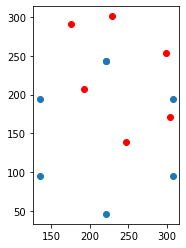

In [61]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
plt.scatter(hexagon.get_verts()[:,0],hexagon.get_verts()[:,1])
plt.scatter(N1_211107_P36[:,0],N1_211107_P36[:,1], color='r')
plt.autoscale(enable = True)

In [87]:
fixed = np.zeros((400,400))
for i in hexagon.get_verts():
    # print(i)# 
    fixed[int(i[1]),int(i[0])] = 1

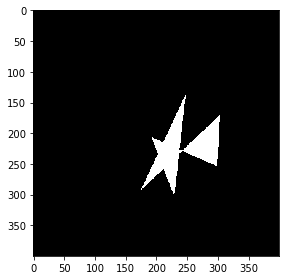

In [98]:
image = np.zeros((400,400))

N1_211107_P36 = N1_211107_P36.reshape((-1, 1, 2))
 
isClosed = True
 
# Line thickness of 2 px
thickness = 2
 
# Using cv2.polylines() method
# Draw a Blue polygon with
# thickness of 1 px
image1 = cv2.polylines(image, [N1_211107_P36],
                      isClosed, thickness)
image2 = cv2.polylines(image, [N1_211107_P36],
                      isClosed, thickness)
# io.imshow(image2)
image2_filled = np.array(ndimage.binary_fill_holes(image2), dtype=np.float32)
io.imshow(image2_filled)

In [89]:
com = transform_centers_of_mass(static=fixed,
                                static_grid2world=np.eye(3),
                                moving=moving,
                                moving_grid2world=np.eye(3)
                               )

In [90]:
img2 = com.transform(moving)

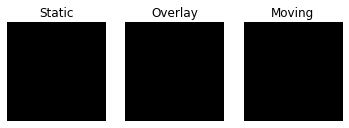

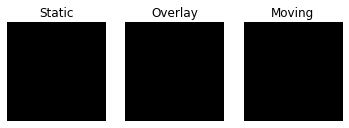

In [91]:
regtools.overlay_images(fixed, moving, 'Static', 'Overlay', 'Moving',
                        'input_images.png')

(array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        ...,
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.]], dtype=float32),
 array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        ...,
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.]], dtype=float32))

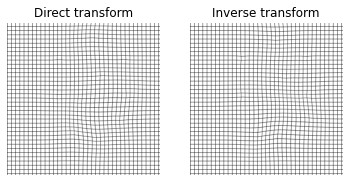

In [95]:
dim = fixed.ndim
metric = SSDMetric(dim)
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)
mapping = sdr.optimize(fixed, moving)
regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

In [15]:
p.vertices

[Point2D(1, 0),
 Point2D(1/2, sqrt(3)/2),
 Point2D(-1/2, sqrt(3)/2),
 Point2D(-1, 0),
 Point2D(-1/2, -sqrt(3)/2),
 Point2D(1/2, -sqrt(3)/2)]

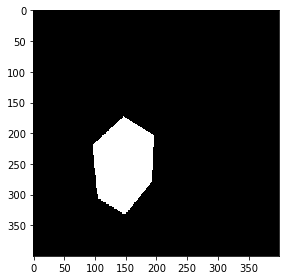

In [192]:
image = np.zeros((400,400))

N2_P36_211107 = N2_P36_211107.reshape((-1, 1, 2))
 
isClosed = True
 
# Line thickness of 2 px
thickness = 2
 
# Using cv2.polylines() method
# Draw a Blue polygon with
# thickness of 1 px
image1 = cv2.polylines(image, [N2_P36_211107],
                      isClosed, thickness)
image2 = cv2.polylines(image, [N2_P36_211107],
                      isClosed, thickness)
# io.imshow(image2)
image2_filled = np.array(ndimage.binary_fill_holes(image2), dtype=np.float32)
io.imshow(image2_filled)

In [209]:
reg_hex = np.array([[200,0],
                    [26.8,100],
                    [26.8,300],
                    [200,400],
                    [373.2,300],
                    [373.2,100]
                   ], np.int32)

/opt/anaconda3/envs/ants/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning:

Low image data range; displaying image with stretched contrast.



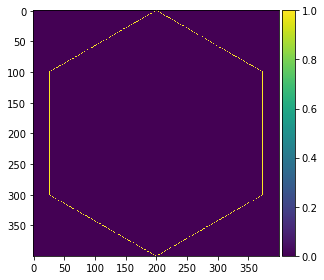

In [210]:
image = np.zeros((400,400))

reg_hex = reg_hex.reshape((-1, 1, 2))
 
isClosed = True
 
# Line thickness of 2 px
thickness = 2
 
# Using cv2.polylines() method
# Draw a Blue polygon with
# thickness of 1 px
image1 = cv2.polylines(image, [reg_hex],
                      isClosed, thickness)
# io.imshow(image2)
image1_filled = np.array(ndimage.binary_fill_holes(image1), dtype=np.float32)
io.imshow(image1_filled)

In [211]:
com = transform_centers_of_mass(static=image1_filled,
                                static_grid2world=np.eye(3),
                                moving=image2_filled,
                                moving_grid2world=np.eye(3)
                               )

In [212]:
img2_neuron = com.transform(image2_filled)

In [214]:
hex_test1 = np.array([26.8,300]) - np.array([373.2,100])
hex_test2 = np.array([26.8,100]) - np.array([373.2,300])
hex_test3 = np.array([200,0]) - np.array([200,400])

In [215]:
np.linalg.norm(hex_test1)

399.9911999031978

In [216]:
np.linalg.norm(hex_test2)

399.9911999031978

In [217]:
np.linalg.norm(hex_test3)

400.0

In [200]:
moving = img2_neuron
static = image1_filled

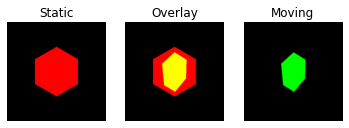

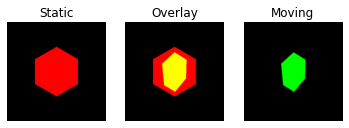

In [174]:
regtools.overlay_images(static, moving, 'Static', 'Overlay', 'Moving',
                        'input_images.png')

In [175]:
dim = static.ndim
metric = SSDMetric(dim)

In [176]:
level_iters = [200, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)

In [177]:
mapping = sdr.optimize(static, moving)


(array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        ...,
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.]], dtype=float32),
 array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        ...,
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.]], dtype=float32))

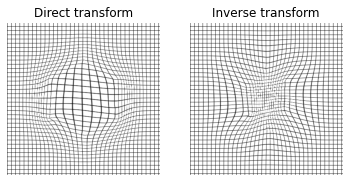

In [178]:
regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

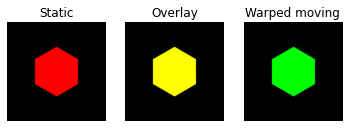

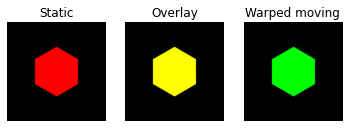

In [181]:
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Static', 'Overlay',
                        'Warped moving', 'direct_warp_result.png')

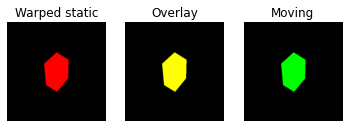

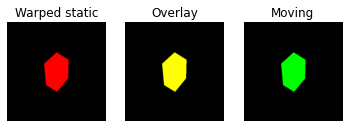

In [182]:
warped_static = mapping.transform_inverse(static, 'linear')
regtools.overlay_images(warped_static, moving, 'Warped static', 'Overlay',
                        'Moving', 'inverse_warp_result.png')

In [183]:
test = tifffile.imread('/Users/hoermann/Desktop/TLI_project/Data/T4/211107_P36_N2_R250_5D.tif',)

In [184]:
green = test[:,:,1,:,:]
red = test[:,:,0,:,:]

In [185]:
green = green-green.min()
red = red-red.min()

In [186]:
green = np.int16(green)
red = np.int16(red)

In [187]:
green_transformed = np.zeros(green.shape, np.int16)
red_transformed = np.zeros(red.shape, np.int16)

In [188]:
for timepoint in tqdm.tqdm(range(0,green.shape[0])):
    for vol_slice in range(0,green.shape[1]):
        green_transformed[timepoint,vol_slice] = mapping.transform(com.transform(green[timepoint, vol_slice]))
        red_transformed[timepoint,vol_slice] = mapping.transform(com.transform(red[timepoint, vol_slice]))

100%|████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:45<00:00,  1.15s/it]


In [189]:
tifffile.imwrite(file='/Users/hoermann/Desktop/TLI_project/Analysis/Normalization/211107_N2_g.tif', data=green_transformed, **{'imagej':'TZYX', 'bigtiff':True})
tifffile.imwrite(file='/Users/hoermann/Desktop/TLI_project/Analysis/Normalization/211107_N2_r.tif', data=red_transformed, **{'imagej':'TZYX', 'bigtiff':True})

/opt/anaconda3/envs/ants/lib/python3.9/site-packages/tifffile/tifffile.py:1221: UserWarning:

<tifffile.TiffWriter '211107_N2_g.tif'> writing nonconformant BigTIFF ImageJ

/opt/anaconda3/envs/ants/lib/python3.9/site-packages/tifffile/tifffile.py:1221: UserWarning:

<tifffile.TiffWriter '211107_N2_r.tif'> writing nonconformant BigTIFF ImageJ



In [175]:
im = image

(400, 400)

In [223]:
from skimage.measure import label, regionprops, regionprops_table
import skimage.io as io
test1= tif.imread('3D binary image of neuron')
regions = regionprops(test1.astype(int))
regions[0].area

In [232]:
regions[0].area, regions[0].area_filled, regions[0].axis_major_length

(274576, 274676, 218.63157613053025)

In [ ]:
['area', 'centroid', ]